#### https://mapr.com/blog/tips-and-best-practices-to-take-advantage-of-spark-2-x/
#### https://towardsdatascience.com/pyspark-and-sparksql-basics-6cb4bf967e53
#### https://github.com/pinarersoy/PySpark_SparkSQL_MLib/blob/master/PySpark%20and%20SparkSQL.ipynb
#### https://rsandstroem.github.io/sparkkmeans.html
#### https://datascience-enthusiast.com/Python/ml_RDD_DataFrames.html
#### https://github.com/jadianes/spark-py-notebooks
#### https://github.com/jlyang1990/Spark_Python_Do_Big_Data_Analytics

In [1]:
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.types import *
sc = SparkContext(appName="UseParquet")
sqlContext = SQLContext(sc)
# Read in the Parquet file created above.
# Parquet files are self-describing so the schema is preserved.
# The result of loading a parquet file is also a DataFrame.
taxiparquet = sqlContext.read.parquet('./work/yellow_tripdata_2016-06-parquet')
def prettySummary(df):
    """ Neat summary statistics of a Spark dataframe
    Args:
        pyspark.sql.dataframe.DataFrame (df): input dataframe
    Returns:
        pandas.core.frame.DataFrame: a pandas dataframe with the summary statistics of df
    """
    import pandas as pd
    temp = df.describe().toPandas()
    temp.iloc[1:3,1:] = temp.iloc[1:3,1:].apply(pd.to_numeric, errors='coerce')
    pd.options.display.float_format = '{:,.2f}'.format
    return temp
prettySummary(taxiparquet)

,summary,vendor_id,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code_id,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,count,11135470,11135470,11135470,11135470,11135470,11135470,11135470,11135470,11135470,11135470,11135470,11135470,11135470,11135470,11135470,11135470,11135470
1,mean,1.53,1.66,3.04,-73.05,40.24,1.04,NaN,-73.12,40.28,1.35,13.51,0.34,0.50,1.84,0.34,0.30,16.83
2,stddev,0.50,1.30,21.83,8.21,4.52,0.57,NaN,7.88,4.34,0.49,275.54,0.53,0.04,2.71,1.72,0.01,275.86
3,min,1,0,0.0,-118.18626,0.0,1,N,-118.18626,0.0,1,-450.0,-41.23,-2.7,-67.7,-12.5,-0.3,-450.8
4,max,2,9,71732.7,0.0,64.09648,99,Y,106.24688,60.040714,5,628544.75,597.92,60.35,854.85,970.0,11.64,629033.75


In [2]:
taxi_select = taxiparquet.select(['passenger_count','trip_distance','total_amount','tip_amount','payment_type'])

In [3]:
prettySummary(taxi_select)

,summary,passenger_count,trip_distance,total_amount,tip_amount,payment_type
0,count,11135470,11135470,11135470,11135470,11135470
1,mean,1.66,3.04,16.83,1.84,1.35
2,stddev,1.30,21.83,275.86,2.71,0.49
3,min,0,0.0,-450.8,-67.7,1
4,max,9,71732.7,629033.75,854.85,5


In [4]:
from __future__ import print_function
from pyspark import SparkContext
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler

In [5]:
features = ['passenger_count','trip_distance','total_amount','tip_amount']
assembler = VectorAssembler(
    inputCols=features,
    outputCol='features')
assembled_taxi = assembler.transform(taxi_select)
assembled_taxi.show(5)

+---------------+-------------+------------+----------+------------+--------------------+
|passenger_count|trip_distance|total_amount|tip_amount|payment_type|            features|
+---------------+-------------+------------+----------+------------+--------------------+
|              1|          3.1|        15.8|       0.0|           2|[1.0,3.0999999046...|
|              1|         1.38|        9.96|      1.66|           1|[1.0,1.3799999952...|
|              1|         0.94|         6.8|       0.0|           2|[1.0,0.9399999976...|
|              1|          2.9|       22.55|      3.75|           1|[1.0,2.9000000953...|
|              1|          0.8|       11.15|      1.85|           1|[1.0,0.8000000119...|
+---------------+-------------+------------+----------+------------+--------------------+
only showing top 5 rows



In [6]:
taxi_select.head(5)

[Row(passenger_count=1, trip_distance=3.0999999046325684, total_amount=15.800000190734863, tip_amount=0.0, payment_type=2),
 Row(passenger_count=1, trip_distance=1.3799999952316284, total_amount=9.960000038146973, tip_amount=1.659999966621399, payment_type=1),
 Row(passenger_count=1, trip_distance=0.9399999976158142, total_amount=6.800000190734863, tip_amount=0.0, payment_type=2),
 Row(passenger_count=1, trip_distance=2.9000000953674316, total_amount=22.549999237060547, tip_amount=3.75, payment_type=1),
 Row(passenger_count=1, trip_distance=0.800000011920929, total_amount=11.149999618530273, tip_amount=1.850000023841858, payment_type=1)]

In [7]:
print(taxi_select)
print(assembled_taxi)

DataFrame[passenger_count: int, trip_distance: float, total_amount: float, tip_amount: float, payment_type: int]
DataFrame[passenger_count: int, trip_distance: float, total_amount: float, tip_amount: float, payment_type: int, features: vector]


In [8]:
train, test = assembled_taxi.randomSplit([0.6, 0.4], seed=0)
#assembled_df.sample(False,0.4, seed=0)

In [9]:
lr = LinearRegression(maxIter=10).setLabelCol("payment_type").setFeaturesCol("features")
model = lr.fit(train)

In [10]:
testing_summary = model.evaluate(test)

In [11]:
testing_summary.rootMeanSquaredError

0.43303192678194763

In [12]:
testing_summary.predictions.select('passenger_count','trip_distance','total_amount','tip_amount','payment_type','prediction').show(10)

+---------------+-------------+------------+----------+------------+------------------+
|passenger_count|trip_distance|total_amount|tip_amount|payment_type|        prediction|
+---------------+-------------+------------+----------+------------+------------------+
|              0|          0.0|         3.8|       0.0|           2|1.5013795539043826|
|              0|          0.0|        8.16|      1.36|           1|1.3825334814604624|
|              0|          0.0|        8.54|       0.0|           3|1.5014695446837982|
|              0|          0.0|         8.8|       0.0|           1|1.5014744808912242|
|              0|          0.0|       11.75|       0.0|           1|1.5015304878071687|
|              0|          0.0|       29.12|      5.82|           1|0.9929147399101657|
|              0|          0.0|       55.85|       0.0|           1|1.5023677437622172|
|              0|          0.0|       64.34|       6.0|           1|0.9778428377395803|
|              0|          0.0| 

In [13]:
from __future__ import print_function

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import make_blobs
from pyspark import SparkContext
from pyspark.ml.clustering import KMeans, KMeansModel
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SQLContext
from pyspark.mllib.linalg import Vectors
from pyspark.sql.types import Row

In [14]:
from pyspark.sql.functions import monotonically_increasing_id
taxi_select = taxi_select.withColumn("id", monotonically_increasing_id()) 
#move id first (left)
taxi_select = taxi_select.select(['id','passenger_count','trip_distance','total_amount','tip_amount','payment_type'])
features = ['passenger_count','trip_distance','total_amount','tip_amount']
assembler = VectorAssembler(
    inputCols=features,
    outputCol='features')
assembled_taxid_full = assembler.transform(taxi_select).select('id', 'features')
assembled_taxid_full.show(5)

+---+--------------------+
| id|            features|
+---+--------------------+
|  0|[1.0,3.0999999046...|
|  1|[1.0,1.3799999952...|
|  2|[1.0,0.9399999976...|
|  3|[1.0,2.9000000953...|
|  4|[1.0,0.8000000119...|
+---+--------------------+
only showing top 5 rows



In [15]:
# subset of 10000 rows just to make it easy for spark to calculate
assembled_taxid=assembled_taxid_full.where("id < 10000")

In [16]:
cost = np.zeros(12)
for k in range(5,12):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
    model = kmeans.fit(assembled_taxid)
    cost[k] = model.computeCost(assembled_taxid) # requires Spark 2.0 or later

Text(0, 0.5, 'cost')

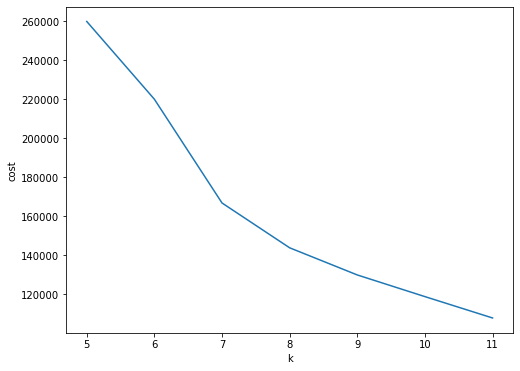

In [17]:
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(5,12),cost[5:12])
ax.set_xlabel('k')
ax.set_ylabel('cost')

In [18]:
k = 10
kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
model = kmeans.fit(assembled_taxid)
centers = model.clusterCenters()

print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[ 1.69353807  3.56321818 20.51594335  2.39653231]
[1.59898734 0.9750962  8.07238999 0.71032405]
[ 1.63538874  9.74455764 41.40026788  4.80911528]
[  1.33333333  24.48000039 137.90666707  17.75333299]
[ 1.65269461 17.1422754  71.82143706 11.13323352]
[  1.          19.70499992 213.65499878  16.83499908]
[ 1.63476874  6.22720893 29.39926602  3.40743222]
[ 1.75776398 10.10913043 53.8369565   8.32801244]
[ 1.60397351  2.02030463 13.64068545  1.55623179]
[ 1.8046875  17.53671873 58.25289041  0.82273437]


In [19]:
transformed = model.transform(assembled_taxid).drop("features").select('id', 'prediction')


In [20]:
rows = transformed.collect()

In [21]:
print(rows[:3])

[Row(id=0, prediction=8), Row(id=1, prediction=1), Row(id=2, prediction=1)]


In [22]:
taxi_pred = sqlContext.createDataFrame(rows)
taxi_pred.show()

+---+----------+
| id|prediction|
+---+----------+
|  0|         8|
|  1|         1|
|  2|         1|
|  3|         0|
|  4|         8|
|  5|         2|
|  6|         1|
|  7|         8|
|  8|         8|
|  9|         8|
| 10|         8|
| 11|         1|
| 12|         1|
| 13|         8|
| 14|         0|
| 15|         0|
| 16|         6|
| 17|         8|
| 18|         8|
| 19|         0|
+---+----------+
only showing top 20 rows



In [23]:
taxi_pred = taxi_pred.join(assembled_taxid, 'id')
taxi_pred.show()

+----+----------+--------------------+
|  id|prediction|            features|
+----+----------+--------------------+
|  26|         8|[1.0,2.7999999523...|
|  29|         0|[1.0,3.6900000572...|
| 474|         0|[1.0,2.5899999141...|
| 964|         1|[1.0,0.8999999761...|
|1677|         1|[1.0,1.3500000238...|
|1697|         1|[1.0,0.5,6.849999...|
|1806|         0|[1.0,1.2000000476...|
|1950|         1|[1.0,1.5,9.300000...|
|2040|         0|[2.0,2.2000000476...|
|2214|         0|[1.0,5.3000001907...|
|2250|         1|[1.0,1.2999999523...|
|2453|         1|[1.0,0.8000000119...|
|2509|         8|[1.0,1.6299999952...|
|2529|         1|[1.0,0.3300000131...|
|2927|         0|[1.0,3.7999999523...|
|3091|         8|[1.0,1.8999999761...|
|3506|         8|[1.0,2.1600000858...|
|3764|         6|[1.0,5.0999999046...|
|4590|         1|[1.0,0.7799999713...|
|4823|         8|[1.0,3.9900000095...|
+----+----------+--------------------+
only showing top 20 rows



In [24]:
pd_pred = taxi_pred.toPandas().set_index('id')
pd_pred.head()

,prediction,features
id,,
26,8,"[1.0, 2.799999952316284, 17.299999237060547, 0.0]"
29,0,"[1.0, 3.690000057220459, 18.799999237060547, 0.0]"
474,0,"[1.0, 2.5899999141693115, 17.760000228881836, ..."
964,1,"[1.0, 0.8999999761581421, 8.300000190734863, 1.0]"
1677,1,"[1.0, 1.350000023841858, 8.300000190734863, 0.0]"
